In [1]:
import warnings, logging
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import os, pickle
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Create TS Datasets

In [2]:
input_columns = [
                "Open (Rs.)",
                "High (Rs.)",
                "Low (Rs.)",
                "Close (Rs.)",
                "TradeVolume",
                "ShareVolume",
                "Turnover (Rs.)"
                ]

output_columns = [
                "Open (Rs.)",
                "Close (Rs.)",
                "TradeVolume",
                "Turnover (Rs.)"
                ]

In [6]:
def create_ts_dataset(
                    csv_path : str,
                    data_path : str,
                    scalar_path : str,
                    selective_window : int = 30 * 6,
                    predictive_window : int = 30 * 3
                    ):
    try:
        if not os.path.exists(data_path):
            df = pd.read_csv(csv_path)
            df = df.dropna()
            df = df.drop_duplicates()
            df = df.reset_index(drop=True)

            df['Trade Date'] = pd.to_datetime(df['Trade Date'], format='%m/%d/%y')
            df = df.sort_values(by='Trade Date', ascending=True)    

            df_x = df[input_columns]
            df_y = df[output_columns]

            X, Y = [], []

            for i in range(len(df) - selective_window - predictive_window):
                x = df_x.iloc[i : i + selective_window].values
                y = df_y.iloc[i + selective_window : i + selective_window + predictive_window].values

                X.append(x)
                Y.append(y)

            X = np.asarray(X)
            Y = np.asarray(Y)

            X_2d = X.reshape(-1, X.shape[-1])
            scaler_x = StandardScaler()
            scaler_x.fit(X_2d)

            Y_2d = Y.reshape(-1, Y.shape[-1])        
            scaler_y = StandardScaler()
            scaler_y.fit(Y_2d)

            X = scaler_x.transform(X_2d).reshape(X.shape)
            Y = scaler_y.transform(Y_2d).reshape(Y.shape)

            with open(scalar_path, 'wb') as f:
                pickle.dump((scaler_x, scaler_y), f)

            Y = [
                Y[:, :, 0],
                Y[:, :, 1],
                Y[:, :, 2],
                Y[:, :, 3]
                ]

            with open(data_path, 'wb') as f:
                pickle.dump((X, Y), f)

        with open(data_path, 'rb') as f:
            X, Y = pickle.load(f)

    except Exception as e:
        print(f"Failed to build TS dataset for company : {csv_path}")
        print(e)

def create_all_datasets(data_dir : str = 'data/Stocks/csvs/'):
    for csv_file in os.listdir(data_dir):
        csv_path = os.path.join(data_dir, csv_file)
        csv_path = csv_path.replace('\\', '/')
        data_path = csv_path.replace('/csvs/', '/objs/').replace('.csv', '.pkl')
        scalar_path = csv_path.replace('data/', 'models/').replace('csvs/', '').replace('.csv', '.pkl')
        create_ts_dataset(csv_path, data_path, scalar_path)

def load_ts_data(data_path):
    with open(data_path, 'rb') as f:
        X, Y = pickle.load(f)
    return X, Y

def load_scalars(scalar_path):
    with open(scalar_path, 'rb') as f:
        scaler_x, scaler_y = pickle.load(f)
    return scaler_x, scaler_y

def get_company_list(data_dir : str = 'data/Stocks/csvs/'):
    company_list = []
    for csv_file in os.listdir(data_dir):
        company_list.append(csv_file.replace('.N0000.csv', '').replace('.X0000.csv', ''))
    return company_list

In [7]:
create_all_datasets()

### Build Deep TS Models

In [8]:
def build_ts_model(                    
                    selective_window : int = 30 * 6,
                    predictive_window : int = 30 * 3
                    ):
    inp = tf.keras.layers.Input(shape=(selective_window, len(input_columns)))
    x = tf.keras.layers.LSTM(256, return_sequences=True)(inp)
    x = tf.keras.layers.LSTM(256)(x)

    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    op1 = tf.keras.layers.Dense(predictive_window, name='OpenPrice')(x)
    op2 = tf.keras.layers.Dense(predictive_window, name='ClosePrice')(x)
    op3 = tf.keras.layers.Dense(predictive_window, name='TradeVolume')(x)
    op4 = tf.keras.layers.Dense(predictive_window, name='Turnover')(x)

    model = tf.keras.models.Model(
                                inputs=inp, 
                                outputs=[op1, op2, op3, op4]
                                )

    model.compile(
                loss='mse',
                optimizer='adam', 
                metrics=['mae','mae','mae','mae']
                )
    return model

In [9]:
def train_ts_model_on_company(
                            company_symbol : str,
                            model_path : str = 'models/Stocks/{}.{}.h5',
                            data_path : str = 'data/Stocks/objs/{}.{}.pkl',
                            history_path : str = 'experiments/Stocks/{}.{}.pkl'
                            ):
        if os.path.exists(model_path.format(company_symbol, 'N0000')) and os.path.exists(history_path.format(company_symbol, 'N0000')):
                return

        if os.path.exists(model_path.format(company_symbol, 'X0000')) and os.path.exists(history_path.format(company_symbol, 'X0000')):
                return
          
        if os.path.exists(data_path.format(company_symbol, 'N0000')):
                comp_ext = 'N0000'
        elif os.path.exists(data_path.format(company_symbol, 'X0000')):
                comp_ext = 'X0000'
        else:
                comp_ext = None
        AssertionError(comp_ext is not None, "Data Path Must Exists !!!")

        X, Y = load_ts_data(data_path.format(company_symbol, comp_ext))
        model = build_ts_model()
        history = model.fit(
                        X, Y, 
                        epochs=100, 
                        batch_size=16,
                        verbose=0
                        )
        model.save(model_path.format(company_symbol, comp_ext))

        with open(history_path.format(company_symbol, comp_ext), 'wb') as f:
                pickle.dump(history.history, f)

### Train TS Models on All Companies

In [7]:
company_list = get_company_list()
for company in company_list:
    train_ts_model_on_company(company)
    print(f'{company} TS Model Trained Successfully')

ABAN TS Model Trained Successfully
ACL TS Model Trained Successfully
ACME TS Model Trained Successfully
AEL TS Model Trained Successfully
AGAL TS Model Trained Successfully
AMSL TS Model Trained Successfully
APLA TS Model Trained Successfully
ASIR TS Model Trained Successfully
BIL TS Model Trained Successfully
BLUE TS Model Trained Successfully
BPPL TS Model Trained Successfully
CABO TS Model Trained Successfully
CALF TS Model Trained Successfully
CARG TS Model Trained Successfully
CCS TS Model Trained Successfully
CFLB TS Model Trained Successfully
CHL TS Model Trained Successfully
CHOT TS Model Trained Successfully
CIC TS Model Trained Successfully
CIT TS Model Trained Successfully
COCR TS Model Trained Successfully
COMD TS Model Trained Successfully
CONN TS Model Trained Successfully
CRL TS Model Trained Successfully
CTBL TS Model Trained Successfully
CTC TS Model Trained Successfully
CTEA TS Model Trained Successfully
CTHR TS Model Trained Successfully
DIAL TS Model Trained Success

### Plot Losses and Metrics

In [8]:
def load_history(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    return history

def plot_history(history_dir : str = 'experiments/Stocks/'):

    n_stocks = len(os.listdir(history_dir))
    n_cols, n_rows = 6, n_stocks // 6

    plt.figure(figsize=(20, 6*n_rows))
    for idx, history_file in enumerate(os.listdir(history_dir)[:n_cols*n_rows]):
        company_symbol = history_file.split('.')[0]
        history_path = os.path.join(history_dir, history_file)
        history_path = history_path.replace('\\', '/')
        history = load_history(history_path)

        plt.subplot(n_rows, n_cols, idx + 1)
        plt.plot(history['OpenPrice_mae'], label='Open Price MAE')
        plt.plot(history['ClosePrice_mae'], label='Close Price MAE')
        plt.plot(history['TradeVolume_mae'], label='Trade Volume MAE')
        plt.plot(history['Turnover_mae'], label='Turnover MAE')
        plt.legend()

        plt.title(f'{company_symbol}')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')

    plt.show()

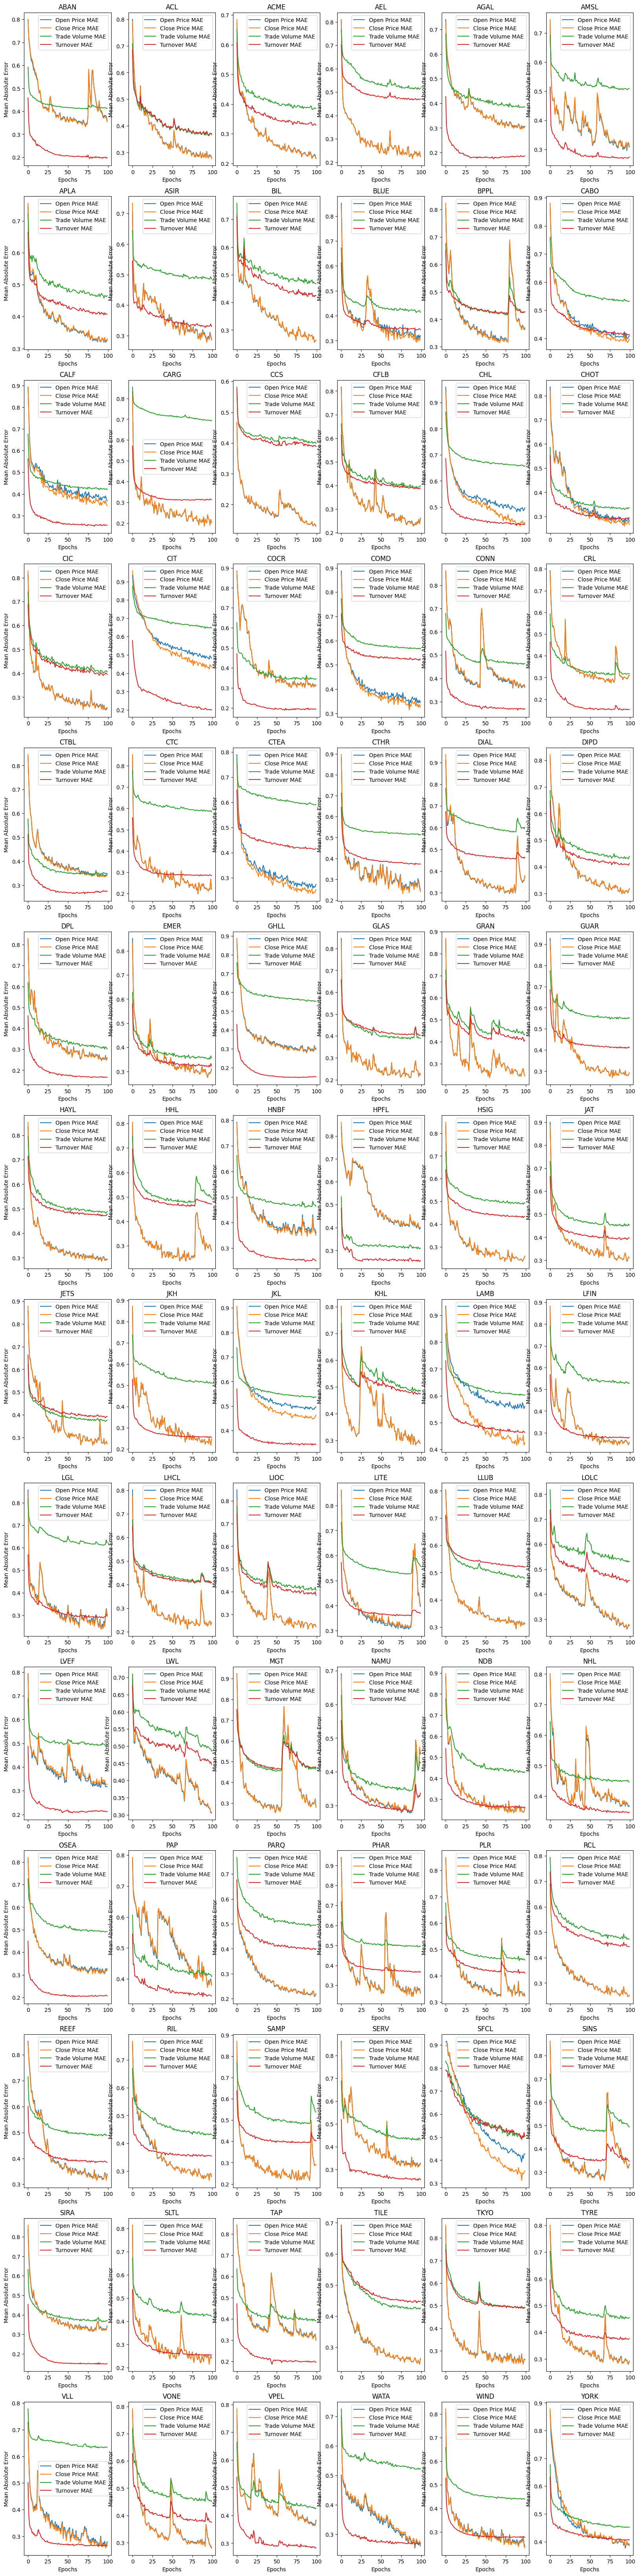

In [9]:
plot_history()

### Inference

In [19]:
import warnings, logging, os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import os, pickle
import numpy as np 
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [20]:
input_columns = [
                "Open (Rs.)",
                "High (Rs.)",
                "Low (Rs.)",
                "Close (Rs.)",
                "TradeVolume",
                "ShareVolume",
                "Turnover (Rs.)"
                ]

output_columns = [
                "Open (Rs.)",
                "Close (Rs.)",
                "TradeVolume",
                "Turnover (Rs.)"
                ]

In [21]:
def load_ts_data(data_path):
    with open(data_path, 'rb') as f:
        X, Y = pickle.load(f)
    return X, Y

def load_scalars(scalar_path):
    with open(scalar_path, 'rb') as f:
        scaler_x, scaler_y = pickle.load(f)
    return scaler_x, scaler_y

def get_company_list(data_dir : str = 'data/Stocks/csvs/'):
    company_list = []
    for csv_file in os.listdir(data_dir):
        company_list.append(csv_file.replace('.N0000.csv', '').replace('.X0000.csv', ''))
    return company_list

def load_ts_models_scalars(
                            model_dir : str = 'models/Stocks/',
                            scalar_dir : str = 'models/Stocks/'
                            ):
    company_list = get_company_list()
    model_dict, scalar_dict = {}, {}

    for company in company_list:
        model_path = os.path.join(model_dir, f'{company}.N0000.h5')
        model_path = model_path.replace('\\', '/')

        if not os.path.exists(model_path):
            model_path = model_path.replace('N0000', 'X0000')

        model = tf.keras.models.load_model(
                                            model_path, 
                                            custom_objects={
                                                            'mse': 'mse',
                                                            'mae': 'mae'
                                                            }
                                            )
        model.compile(
                    loss='mean_squared_error',
                    optimizer='adam', 
                    metrics=['mae','mae','mae','mae']
                    )
        model.compiled_metrics == None
        
        model_dict[company] = model

        scalar_path = os.path.join(scalar_dir, f'{company}.N0000.pkl')
        scalar_path = scalar_path.replace('\\', '/')

        if not os.path.exists(scalar_path):
            scalar_path = scalar_path.replace('N0000', 'X0000')

        scalar = load_scalars(scalar_path)
        scalar_dict[company] = scalar

    return model_dict, scalar_dict

def inference_ts_on_company(            
                            model_dict : dict,
                            scalar_dict : dict,                 
                            company_symbol : str,
                            selective_window : int = 30 * 6,
                            data_path : str = 'data/Stocks/csvs/{}.{}.csv',
                            ):
    model = model_dict[company_symbol]
    scalar_x, scalar_y = scalar_dict[company_symbol]

    if os.path.exists(data_path.format(company_symbol, 'N0000')):
        comp_ext = 'N0000'
    elif os.path.exists(data_path.format(company_symbol, 'X0000')):
        comp_ext = 'X0000'
    else:
        AssertionError(comp_ext is not None, "Data Path Must Exists !!!")

    df = pd.read_csv(data_path.format(company_symbol, comp_ext))
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)

    df['Trade Date'] = pd.to_datetime(df['Trade Date'], format='%m/%d/%y')
    df = df.sort_values(by='Trade Date', ascending=True)    
    df = df.tail(selective_window)
    df = df.reset_index(drop=True)

    df_x = df[input_columns]
    x = df_x.values
    x = scalar_x.transform(x)
    x = x.reshape(1, x.shape[0], x.shape[1])

    p = model.predict(x, verbose=0)
    p = np.asarray(p).reshape(-1, 4)
    p = scalar_y.inverse_transform(p)
    p = np.abs(p)
    
    p_open = p[:, 0].squeeze()
    p_close = p[:, 1].squeeze()
    p_trade = p[:, 2].squeeze()
    p_turnover = p[:, 3].squeeze()

    y_open = df['Open (Rs.)'].values
    y_close = df['Close (Rs.)'].values
    y_trade = df['TradeVolume'].values
    y_turnover = df['Turnover (Rs.)'].values

    avg_p_open = np.mean(p_open)
    avg_p_close = np.mean(p_close)
    avg_p_trade = np.mean(p_trade)
    avg_p_turnover = np.mean(p_turnover)

    avg_y_open = np.mean(y_open)
    avg_y_close = np.mean(y_close)
    avg_y_trade = np.mean(y_trade)
    avg_y_turnover = np.mean(y_turnover)

    change_open_percent = ((avg_p_open - avg_y_open) / avg_y_open) * 100
    change_close_percent = ((avg_p_close - avg_y_close) / avg_y_close) * 100
    change_trade_percent = ((avg_p_trade - avg_y_trade) / avg_y_trade) * 100
    change_turnover_percent = ((avg_p_turnover - avg_y_turnover) / avg_y_turnover) * 100

    return {
            'Change Open Price (%)': change_open_percent,
            'Change Close Price (%)': change_close_percent,
            'Change Trade Volume (%)': change_trade_percent,
            'Change Turnover (%)': change_turnover_percent
            }


In [22]:
model_dict, scalar_dict = load_ts_models_scalars()

In [23]:
inference_ts_on_company(model_dict, scalar_dict, 'SINS')

{'Change Open Price (%)': -1.8581721486940521,
 'Change Close Price (%)': -1.6234033154067806,
 'Change Trade Volume (%)': 69.96272327853417,
 'Change Turnover (%)': 36.97519870061982}

### Forecast on Industry

In [24]:
def inference_on_company(company_symbol : str):
    return inference_ts_on_company(model_dict, scalar_dict, company_symbol)

In [25]:
def inference_on_industry(
                        industry,
                        company_industry_file : str = 'data/Stocks/Company Industry groups V2.csv'
                        ):
    df = pd.read_csv(company_industry_file)
    df = df[['Industry', 'Symbol']]
    df['Symbol'] = df['Symbol'].apply(lambda x: x.replace('.N0000', '').replace('.X0000', ''))
    df = df[df['Industry'] == industry]
    
    company_list = df['Symbol'].values

    results = {}
    results['Change Open Price (%)'] = []
    results['Change Close Price (%)'] = []
    results['Change Trade Volume (%)'] = []
    results['Change Turnover (%)'] = []

    for company in company_list:
        try:
            result = inference_ts_on_company(model_dict, scalar_dict, company)
            results['Change Open Price (%)'].append(result['Change Open Price (%)'])
            results['Change Close Price (%)'].append(result['Change Close Price (%)'])
            results['Change Trade Volume (%)'].append(result['Change Trade Volume (%)'])
            results['Change Turnover (%)'].append(result['Change Turnover (%)'])
        except:
            pass

    df_results = pd.DataFrame(results)
    df_results = df_results[df_results['Change Open Price (%)'] < 100]
    avg_change_open = np.mean(df_results['Change Open Price (%)'])
    avg_change_close = np.mean(df_results['Change Close Price (%)'])
    avg_change_trade = np.mean(df_results['Change Trade Volume (%)'])
    avg_change_turnover = np.mean(df_results['Change Turnover (%)'])

    return {
            'Change Open Price (%)': avg_change_open,
            'Change Close Price (%)': avg_change_close,
            'Change Trade Volume (%)': avg_change_trade,
            'Change Turnover (%)': avg_change_turnover
            }

In [26]:
inference_on_industry("Agricultural Raw Materials")

{'Change Open Price (%)': -12.665186610203582,
 'Change Close Price (%)': -12.722234664880753,
 'Change Trade Volume (%)': 31.82536944719604,
 'Change Turnover (%)': 12.428650729691725}

In [27]:
inference_on_company('SINS')

{'Change Open Price (%)': -1.8581721486940521,
 'Change Close Price (%)': -1.6234033154067806,
 'Change Trade Volume (%)': 69.96272327853417,
 'Change Turnover (%)': 36.97519870061982}